In [1]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'


if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500

model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:00] Epoch 1/500 - Train Loss : 1.021257 / Val Loss : 0.996447
[00:30] Epoch 100/500 - Train Loss : 0.908504 / Val Loss : 1.038425
[01:00] Epoch 200/500 - Train Loss : 0.814219 / Val Loss : 1.162450
[01:31] Epoch 300/500 - Train Loss : 0.727427 / Val Loss : 1.207356
[02:01] Epoch 400/500 - Train Loss : 0.684563 / Val Loss : 1.230119
[02:32] Epoch 500/500 - Train Loss : 0.655819 / Val Loss : 1.269374
Train MAE : 0.6122 | Train MAPE  : 2.4835 | Train RMSE : 0.7958 | Train Theil-U 0.5128
Valid MAE : 0.8828 | Valid MAPE  : 2.5623 | Valid RMSE : 1.1267 | Valid Theil-U 0.7444


### Evaluation

In [7]:
if NNtype != "PSN":
    model.evaluate(testloader, mu=testmu, sigma=testsigma)
else:
    model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006236 | Test MAPE  : 135.742259 | Test RMSE : 0.008300 | Test Theil-U 0.732907


### PREDICT

(array([  3.,   5.,  19.,  88., 139.,  46.,  18.,   1.,   1.,   1.]),
 array([-0.01547534, -0.01182421, -0.00817309, -0.00452196, -0.00087084,
         0.00278029,  0.00643141,  0.01008254,  0.01373366,  0.01738478,
         0.02103591]),
 <a list of 10 Patch objects>)

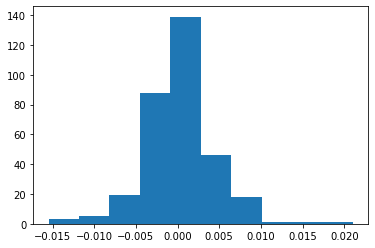

In [8]:
if NNtype != "PSN":
    predictions = model.predict(testloader, mu=testmu, sigma=testsigma)
else:
    predictions = model.predict(testloader, min_=min_, max_=max_)
plt.hist(np.array(predictions))

Text(0.5, 1.0, 'UnNormalized')

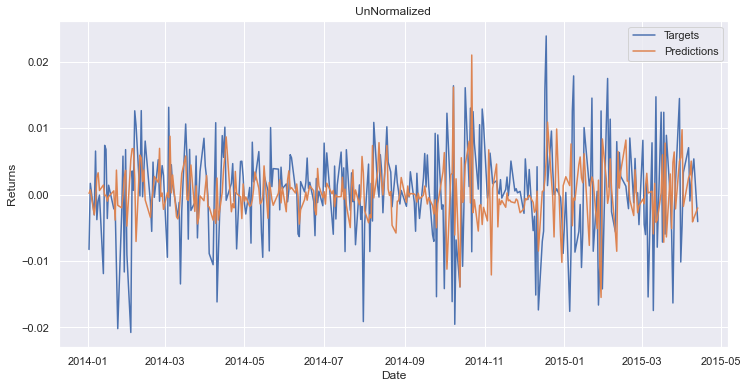

In [9]:
if NNtype == "PSN":
    targets = testdf["Target"]*(max_ - min_) + min_
else :
    targets = testdf["Target"].tolist()

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

# x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [17]:
ETF = 'QQQ'
NNtype = 'PSN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    max_test, min_test = testdf.Return.max(), testdf.Return.min()
    
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_test) / (max_test - min_test)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:32] Epoch 100/200 - Train Loss : 0.014434 / Val Loss : 0.006007
[01:03] Epoch 200/200 - Train Loss : 0.014471 / Val Loss : 0.005910
Train MAE : 0.0892 | Train MAPE  : 0.1774 | Train RMSE : 0.1181 | Train Theil-U 0.1033
Valid MAE : 0.0603 | Valid MAPE  : 0.1049 | Valid RMSE : 0.0769 | Valid Theil-U 0.0678


Normalized Test MAE : 0.006818 | Test MAPE  : 23696.160058 | Test RMSE : 0.009031 | Test Theil-U 0.729137
Test MAE : 0.006818 | Test MAPE  : 1.862060 | Test RMSE : 0.009031 | Test Theil-U 0.729137


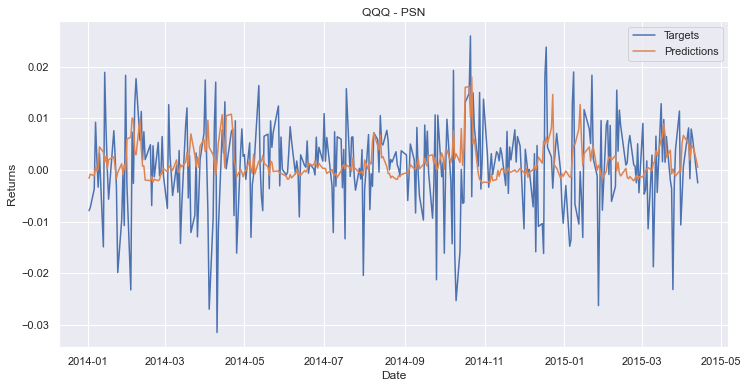

In [18]:
if NNtype == "PSN":
    model.evaluate(testloader, min_=min_test, max_=max_test)
    preds = model.predict(testloader, min_=min_test, max_=max_test)
    labels = testdf["Target"]*(max_test - min_test) + min_test
else :
    model.evaluate(testloader, sigma=testsigma, mu=testmu)
    preds = model.predict(testloader, sigma=testsigma, mu=testmu)
    labels = np.array(testdf["Target"].tolist())

testRMSE = np.sqrt(mean_squared_error(labels, preds))
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
testTheilU = theilU(np.array(labels), np.array(preds))

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show() 

# Test par NNtype

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.999676 / Val Loss : 1.008861
[00:33] Epoch 100/200 - Train Loss : 0.901218 / Val Loss : 0.999897
[01:05] Epoch 200/200 - Train Loss : 0.861816 / Val Loss : 1.073562
Train MAE : 0.6572 | Train MAPE  : 171.0236 | Train RMSE : 0.9294 | Train Theil-U 0.6663
Valid MAE : 0.7837 | Valid MAPE  : 139.0235 | Valid RMSE : 1.0361 | Valid Theil-U 0.7637
Normalized Test MAE : 0.005833 | Test MAPE  : 198.553880 | Test RMSE : 0.007688 | Test Theil-U 0.759745
Test MAE : 0.005838 | Test MAPE  : 170.224113 | Test RMSE : 0.007647 | Test Theil-U 0.754666


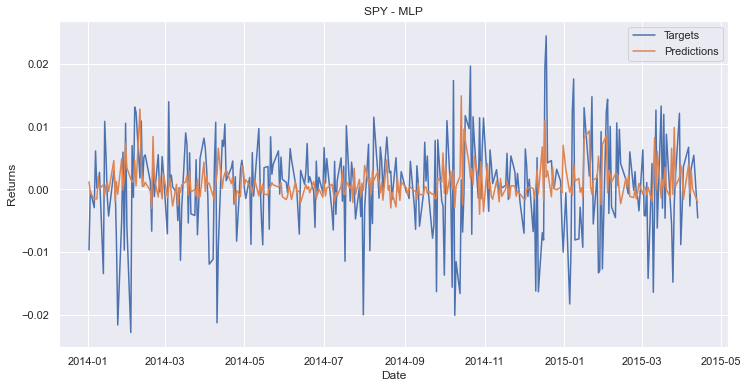

==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 1.028970 / Val Loss : 0.992067
[00:33] Epoch 100/200 - Train Loss : 0.951961 / Val Loss : 1.012624
[01:08] Epoch 200/200 - Train Loss : 0.813767 / Val Loss : 1.067347
Train MAE : 0.6572 | Train MAPE  : 249.0259 | Train RMSE : 0.8932 | Train Theil-U 0.6547
Valid MAE : 0.7931 | Valid MAPE  : 174.4668 | Valid RMSE : 1.0331 | Valid Theil-U 0.7698
Normalized Test MAE : 0.005757 | Test MAPE  : 51113.078228 | Test RMSE : 0.007579 | Test Theil-U 0.771064
Test MAE : 0.005773 | Test MAPE  : 168.703313 | Test RMSE : 0.007568 | Test Theil-U 0.769344


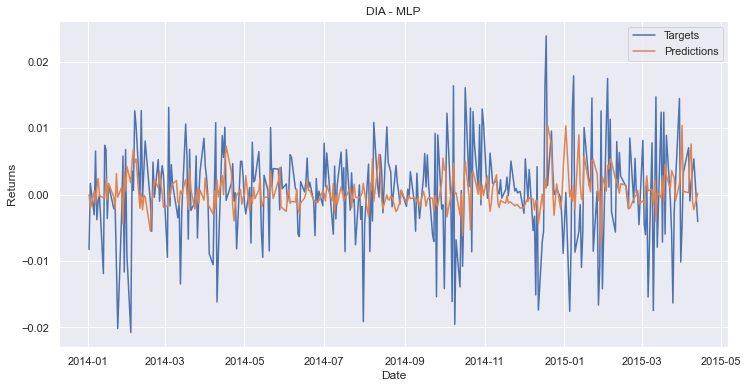

==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 1.022756 / Val Loss : 1.005094
[00:36] Epoch 100/200 - Train Loss : 0.923962 / Val Loss : 0.968877
[01:13] Epoch 200/200 - Train Loss : 0.771031 / Val Loss : 1.045630
Train MAE : 0.6592 | Train MAPE  : 214.6222 | Train RMSE : 0.8593 | Train Theil-U 0.5913
Valid MAE : 0.7760 | Valid MAPE  : 266.2921 | Valid RMSE : 1.0226 | Valid Theil-U 0.7357
Normalized Test MAE : 0.007162 | Test MAPE  : 675.974770 | Test RMSE : 0.009519 | Test Theil-U 0.779019
Test MAE : 0.007233 | Test MAPE  : 215.766754 | Test RMSE : 0.009540 | Test Theil-U 0.779103


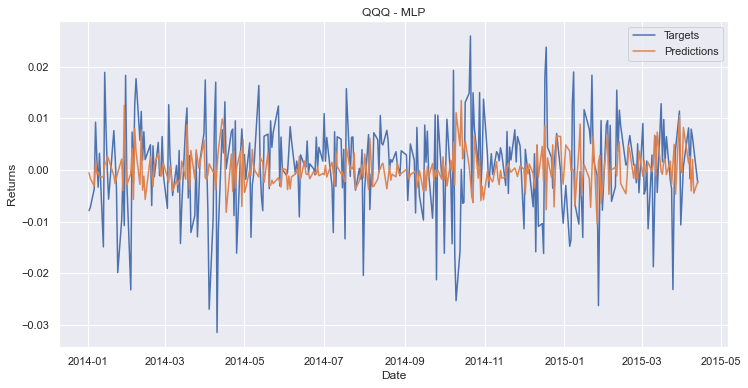

In [4]:
# train all models of a particular NNType
for ETF in ['SPY', 'DIA', 'QQQ']:
    NNtype = 'MLP'

    print("="*10 + ETF + " - " + NNtype + "="*10)
    params = cfg.train_parameters[ETF][NNtype]
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'

    if NNtype != "PSN":
        trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
        validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
        testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    else:
        max_ = traindf.Return.max()
        min_ = traindf.Return.min()
        
        traindf = (traindf - min_) / (max_ - min_)
        validdf = (validdf - min_) / (max_ - min_)
        testdf = (testdf - min_) / (max_ - min_)

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

    model = NN.Model(NNtype)
    epochs = 200
#     epochs = 200 if NNtype == "PSN" else 500
    model.setup(params["input_size"], 
                params["hidden_size"],
                params["output_size"],
                epochs,#params["epochs"],
                params["optim"],
                params["lr"],
                params["momentum"]
               )

    model.train(trainloader, validloader)

    if NNtype == "PSN":
        model.evaluate(testloader, min_=min_, max_=max_)
        preds = model.predict(testloader, min_=min_, max_=max_)
        labels = testdf["Target"]*(max_ - min_) + min_
    else :
        model.evaluate(testloader, sigma=testsigma, mu=testmu)
        preds = model.predict(testloader, sigma=testsigma, mu=testmu)
        labels = np.array(testdf["Target"].tolist())

    testRMSE = np.sqrt(mean_squared_error(labels, preds))
    testMAE = mean_absolute_error(labels, preds)
    testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
    testTheilU = theilU(np.array(labels), np.array(preds))

    print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

    ## plot Target and Predictions UnNormalized ##
    dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
    dataDf.index = testdf.index
    dataDf

    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
    sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - " + NNtype)
    plt.show() 

==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 1.044897 / Val Loss : 0.984391
[01:00] Epoch 100/200 - Train Loss : 0.773476 / Val Loss : 1.143961
[01:55] Epoch 200/200 - Train Loss : 0.755737 / Val Loss : 1.209322
Train MAE : 0.6348 | Train MAPE  : 344.3884 | Train RMSE : 0.8420 | Train Theil-U 0.5582
Valid MAE : 0.8614 | Valid MAPE  : 188.7006 | Valid RMSE : 1.0997 | Valid Theil-U 0.7042
Normalized Test MAE : 0.006282 | Test MAPE  : 300.183767 | Test RMSE : 0.008200 | Test Theil-U 0.720117
Test MAE : 0.006332 | Test MAPE  : 291.918509 | Test RMSE : 0.008211 | Test Theil-U 0.720152


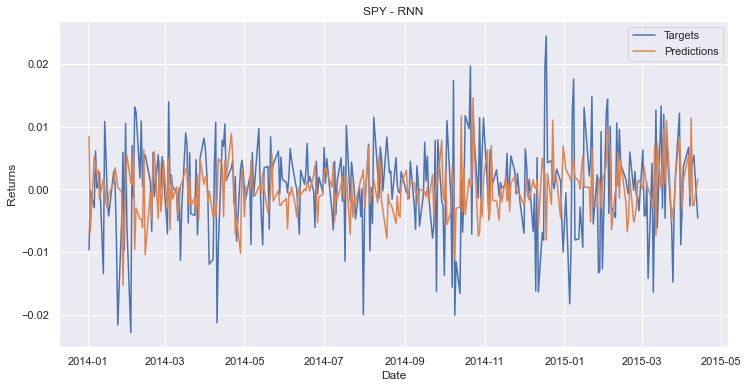

==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 1.053542 / Val Loss : 1.019469
[00:48] Epoch 100/200 - Train Loss : 0.803123 / Val Loss : 1.328554
[01:31] Epoch 200/200 - Train Loss : 0.769750 / Val Loss : 1.368618
Train MAE : 0.6376 | Train MAPE  : 433.6507 | Train RMSE : 0.8536 | Train Theil-U 0.5551
Valid MAE : 0.8998 | Valid MAPE  : 288.4229 | Valid RMSE : 1.1699 | Valid Theil-U 0.7423
Normalized Test MAE : 0.006160 | Test MAPE  : 7473.406991 | Test RMSE : 0.007974 | Test Theil-U 0.700738
Test MAE : 0.006198 | Test MAPE  : 228.394488 | Test RMSE : 0.007979 | Test Theil-U 0.700730


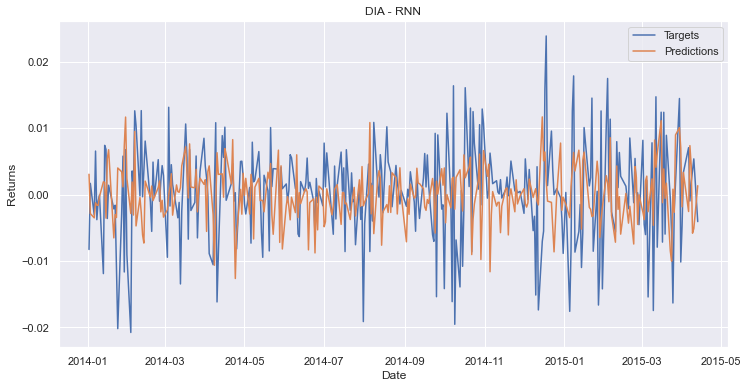

==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 1.033331 / Val Loss : 1.019714
[00:43] Epoch 100/200 - Train Loss : 0.737389 / Val Loss : 1.221167
[01:27] Epoch 200/200 - Train Loss : 0.675664 / Val Loss : 1.254535
Train MAE : 0.6145 | Train MAPE  : 270.9308 | Train RMSE : 0.8024 | Train Theil-U 0.5035
Valid MAE : 0.8719 | Valid MAPE  : 748.0279 | Valid RMSE : 1.1201 | Valid Theil-U 0.6975
Normalized Test MAE : 0.007771 | Test MAPE  : 559.261073 | Test RMSE : 0.010168 | Test Theil-U 0.745393
Test MAE : 0.007805 | Test MAPE  : 272.219990 | Test RMSE : 0.010176 | Test Theil-U 0.744584


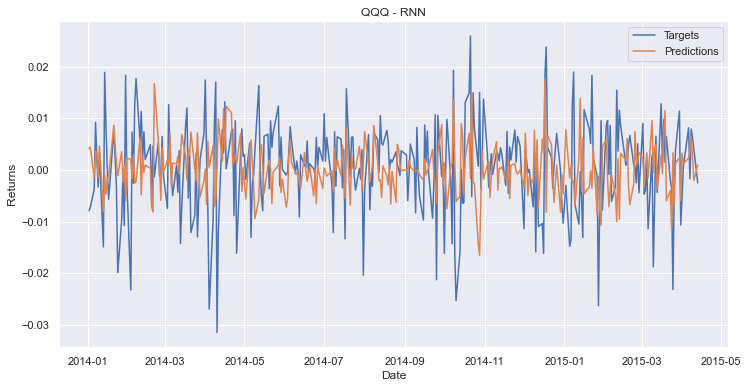

In [5]:
# train all models of a particular NNType
for ETF in ['SPY', 'DIA', 'QQQ']:
    NNtype = 'RNN'

    print("="*10 + ETF + " - " + NNtype + "="*10)
    params = cfg.train_parameters[ETF][NNtype]
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'

    if NNtype != "PSN":
        trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
        validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
        testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    else:
        max_ = traindf.Return.max()
        min_ = traindf.Return.min()
        max_test, min_test = testdf.Return.max(), testdf.Return.min()

        traindf = (traindf - min_) / (max_ - min_)
        validdf = (validdf - min_) / (max_ - min_)
        testdf = (testdf - min_) / (max_ - min_)

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

    model = NN.Model(NNtype)
    epochs = 200
#     epochs = 200 if NNtype == "PSN" else 500
    model.setup(params["input_size"], 
                params["hidden_size"],
                params["output_size"],
                epochs,#params["epochs"],
                params["optim"],
                params["lr"],
                params["momentum"]
               )

    model.train(trainloader, validloader)

    if NNtype == "PSN":
        model.evaluate(testloader, min_=min_, max_=max_)
        preds = model.predict(testloader, min_=min_, max_=max_)
        labels = testdf["Target"]*(max_ - min_) + min_
    else :
        model.evaluate(testloader, sigma=testsigma, mu=testmu)
        preds = model.predict(testloader, sigma=testsigma, mu=testmu)
        labels = np.array(testdf["Target"].tolist())

    testRMSE = np.sqrt(mean_squared_error(labels, preds))
    testMAE = mean_absolute_error(labels, preds)
    testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
    testTheilU = theilU(np.array(labels), np.array(preds))

    print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

    ## plot Target and Predictions UnNormalized ##
    dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
    dataDf.index = testdf.index
    dataDf

    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
    sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - " + NNtype)
    plt.show() 

==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.016037 / Val Loss : 0.005611
[00:31] Epoch 100/200 - Train Loss : 0.012765 / Val Loss : 0.007481
[01:04] Epoch 200/200 - Train Loss : 0.012615 / Val Loss : 0.007486
Train MAE : 0.0913 | Train MAPE  : 16.1500 | Train RMSE : 0.1200 | Train Theil-U 0.1016
Valid MAE : 0.0738 | Valid MAPE  : 11.9507 | Valid RMSE : 0.0865 | Valid Theil-U 0.0744
Normalized Test MAE : 0.008357 | Test MAPE  : 515.953526 | Test RMSE : 0.009792 | Test Theil-U 0.710873
Test MAE : 0.008357 | Test MAPE  : 515.955320 | Test RMSE : 0.009792 | Test Theil-U 0.710873


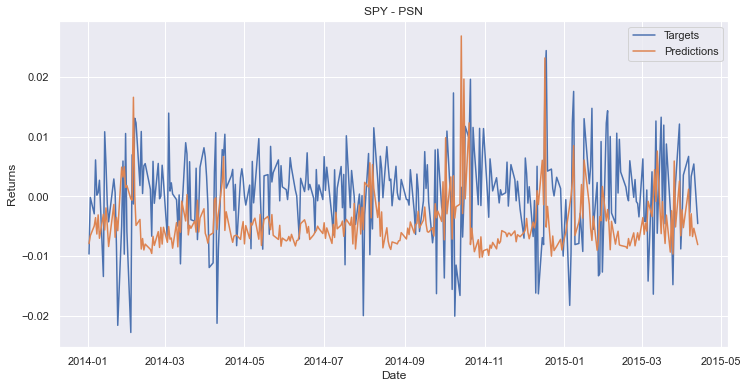

==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020683 / Val Loss : 0.013841
[00:31] Epoch 100/200 - Train Loss : 0.013807 / Val Loss : 0.007053
[01:08] Epoch 200/200 - Train Loss : 0.013701 / Val Loss : 0.007255
Train MAE : 0.0858 | Train MAPE  : 16.4469 | Train RMSE : 0.1168 | Train Theil-U 0.1001
Valid MAE : 0.0700 | Valid MAPE  : 11.6632 | Valid RMSE : 0.0852 | Valid Theil-U 0.0736
Normalized Test MAE : 0.006811 | Test MAPE  : 1877609.495718 | Test RMSE : 0.008344 | Test Theil-U 0.732114
Test MAE : 0.006811 | Test MAPE  : 364070108777867.062500 | Test RMSE : 0.008344 | Test Theil-U 0.732114


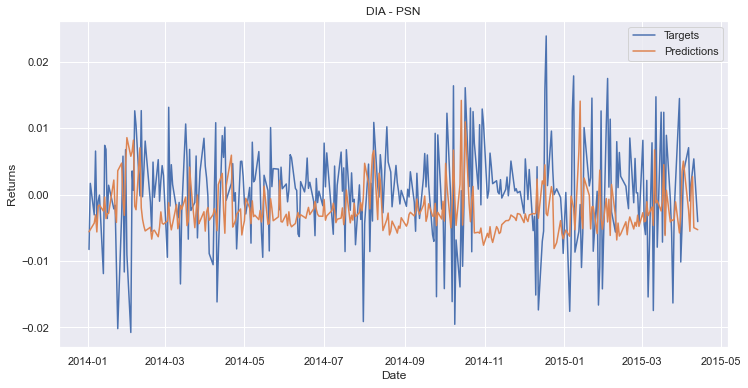

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018492 / Val Loss : 0.011350
[00:42] Epoch 100/200 - Train Loss : 0.014394 / Val Loss : 0.005885
[01:14] Epoch 200/200 - Train Loss : 0.014224 / Val Loss : 0.006003
Train MAE : 0.0888 | Train MAPE  : 17.1447 | Train RMSE : 0.1174 | Train Theil-U 0.1028
Valid MAE : 0.0611 | Valid MAPE  : 10.6239 | Valid RMSE : 0.0775 | Valid Theil-U 0.0683
Normalized Test MAE : 0.007369 | Test MAPE  : 403258.069240 | Test RMSE : 0.009203 | Test Theil-U 0.767081
Test MAE : 0.007369 | Test MAPE  : 181078857473309.187500 | Test RMSE : 0.009203 | Test Theil-U 0.767081


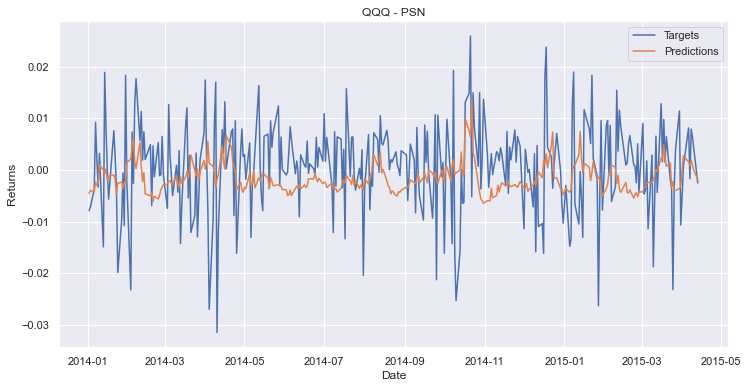

In [10]:
# train all models of a particular NNType
for ETF in ['SPY', 'DIA', 'QQQ']:
    NNtype = 'PSN'

    print("="*10 + ETF + " - " + NNtype + "="*10)
    params = cfg.train_parameters[ETF][NNtype]
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'

    if NNtype != "PSN":
        trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
        validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
        testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    else:
        max_ = traindf.Return.max()
        min_ = traindf.Return.min()
#         max_test, min_test = testdf.Return.max(), testdf.Return.min()

        traindf = (traindf - min_) / (max_ - min_)
        validdf = (validdf - min_) / (max_ - min_)
        testdf = (testdf - min_) / (max_ - min_)
#         testdf = (testdf - min_test) / (max_test - min_test)

        trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
        validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
        testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

    model = NN.Model(NNtype)
    epochs = 200 if NNtype == "PSN" else 500
    model.setup(params["input_size"], 
                params["hidden_size"],
                params["output_size"],
                epochs,#params["epochs"],
                params["optim"],
                params["lr"],
                params["momentum"]
               )

    model.train(trainloader, validloader)

    if NNtype == "PSN":
        model.evaluate(testloader, min_=min_, max_=max_)
        preds = model.predict(testloader, min_=min_, max_=max_)
        labels = testdf["Target"]*(max_ - min_) + min_
        
#         model.evaluate(testloader, min_=min_test, max_=max_test)
#         preds = model.predict(testloader, min_=min_test, max_=max_test)
#         labels = testdf["Target"]*(max_test - min_test) + min_test
    else :
        model.evaluate(testloader, sigma=testsigma, mu=testmu)
        preds = model.predict(testloader, sigma=testsigma, mu=testmu)
        labels = np.array(testdf["Target"].tolist())

    testRMSE = np.sqrt(mean_squared_error(labels, preds))
    testMAE = mean_absolute_error(labels, preds)
    testMAPE = mean_absolute_percentage_error(np.array(labels), np.array(preds))
    testTheilU = theilU(np.array(labels), np.array(preds))

    print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

    ## plot Target and Predictions UnNormalized ##
    dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
    dataDf.index = testdf.index
    dataDf

    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
    sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - " + NNtype)
    plt.show() 

## Train all Models and create Table4

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.021246 / Val Loss : 0.992590
[00:38] Epoch 100/500 - Train Loss : 0.908678 / Val Loss : 1.015536
[01:11] Epoch 200/500 - Train Loss : 0.828375 / Val Loss : 1.066957
[01:42] Epoch 300/500 - Train Loss : 0.802049 / Val Loss : 1.105272
[02:13] Epoch 400/500 - Train Loss : 0.772658 / Val Loss : 1.138276
[02:48] Epoch 500/500 - Train Loss : 0.760965 / Val Loss : 1.172315
Train MAE : 0.6288 | Train MAPE  : 2.3523 | Train RMSE : 0.8670 | Train Theil-U 0.5726
Valid MAE : 0.8304 | Valid MAPE  : 1.7087 | Valid RMSE : 1.0827 | Valid Theil-U 0.7187
Normalized Test MAE : 0.006160 | Test MAPE  : 2.729589 | Test RMSE : 0.008097 | Test Theil-U 0.711342
Test MAE : 0.006131 | Test M

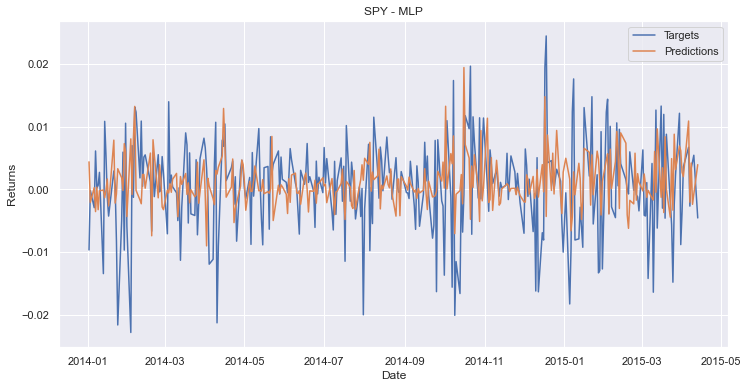




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.064327 / Val Loss : 1.045973
[00:53] Epoch 100/500 - Train Loss : 0.790253 / Val Loss : 1.256309
[01:47] Epoch 200/500 - Train Loss : 0.731034 / Val Loss : 1.382857
[02:41] Epoch 300/500 - Train Loss : 0.720897 / Val Loss : 1.385573
[03:35] Epoch 400/500 - Train Loss : 0.716349 / Val Loss : 1.383202
[04:30] Epoch 500/500 - Train Loss : 0.713441 / Val Loss : 1.379739
Train MAE : 0.6195 | Train MAPE  : 4.1786 | Train RMSE : 0.8290 | Train Theil-U 0.5371
Valid MAE : 0.9181 | Valid MAPE  : 2.1989 | Valid RMSE : 1.1746 | Valid Theil-U 0.7351
Normalized Test MAE : 0.006371 | Test MAPE  : 2.512226 | Test RMSE : 0.008189 | Test Theil-U 0.721020
Test MAE : 0.006375 | Test MAPE  : 228.518788 | Test RMSE : 0.008180 | Test Theil-U 0

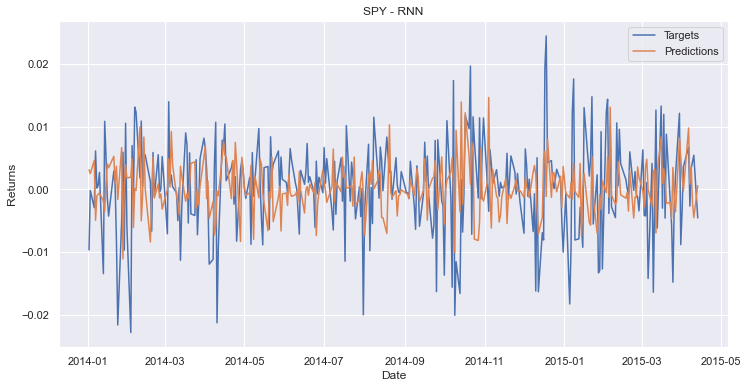




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.016367 / Val Loss : 0.005318
[00:37] Epoch 100/200 - Train Loss : 0.012829 / Val Loss : 0.007492
[01:14] Epoch 200/200 - Train Loss : 0.012602 / Val Loss : 0.007515
Train MAE : 0.0914 | Train MAPE  : 0.1618 | Train RMSE : 0.1203 | Train Theil-U 0.1019
Valid MAE : 0.0738 | Valid MAPE  : 0.1196 | Valid RMSE : 0.0867 | Valid Theil-U 0.0746
Normalized Test MAE : 0.008386 | Test MAPE  : 5.145733 | Test RMSE : 0.009821 | Test Theil-U 0.709969
Test MAE : 0.008386 | Test MAPE  : 514.575035 | Test RMSE : 0.009821 | Test Theil-U 0.709969


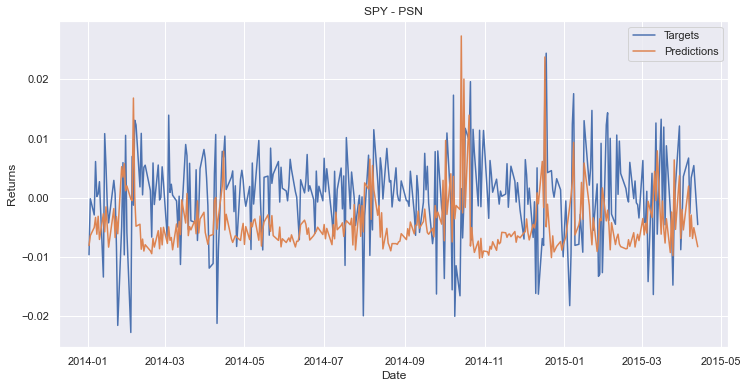




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.031476 / Val Loss : 1.005329
[00:38] Epoch 100/500 - Train Loss : 0.945777 / Val Loss : 1.030532
[01:16] Epoch 200/500 - Train Loss : 0.862146 / Val Loss : 1.072756
[01:56] Epoch 300/500 - Train Loss : 0.766980 / Val Loss : 1.148569
[02:35] Epoch 400/500 - Train Loss : 0.729938 / Val Loss : 1.206089
[03:14] Epoch 500/500 - Train Loss : 0.697938 / Val Loss : 1.233982
Train MAE : 0.6234 | Train MAPE  : 2.9496 | Train RMSE : 0.8219 | Train Theil-U 0.5378
Valid MAE : 0.8662 | Valid MAPE  : 2.5650 | Valid RMSE : 1.1108 | Valid Theil-U 0.7057
Normalized Test MAE : 0.006285 | Test MAPE  : 623.214411 | Test RMSE : 0.008469 | Test Theil-U 0.729860
Test MAE : 0.006297 | T

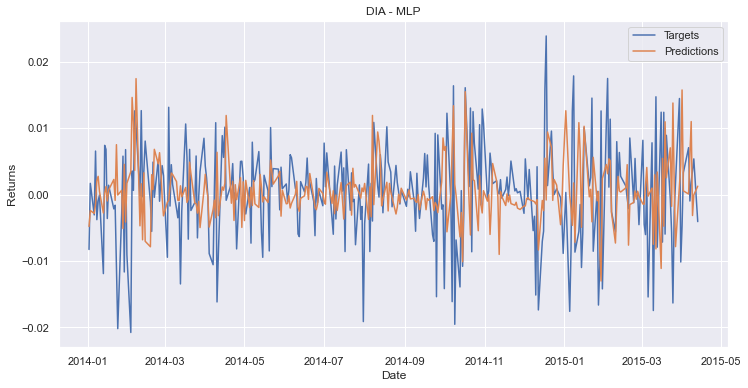




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.033744 / Val Loss : 1.028183
[00:55] Epoch 100/500 - Train Loss : 0.771084 / Val Loss : 1.305062
[01:48] Epoch 200/500 - Train Loss : 0.750151 / Val Loss : 1.332657
[02:44] Epoch 300/500 - Train Loss : 0.737896 / Val Loss : 1.343276
[03:39] Epoch 400/500 - Train Loss : 0.728513 / Val Loss : 1.365184
[04:34] Epoch 500/500 - Train Loss : 0.722933 / Val Loss : 1.395020
Train MAE : 0.6094 | Train MAPE  : 2.5366 | Train RMSE : 0.8269 | Train Theil-U 0.5297
Valid MAE : 0.9187 | Valid MAPE  : 3.0692 | Valid RMSE : 1.1811 | Valid Theil-U 0.7129
Normalized Test MAE : 0.006513 | Test MAPE  : 53.853470 | Test RMSE : 0.008337 | Test Theil-U 0.710165
Test MAE : 0.006523 | Test MAPE  : 248.927200 | Test RMSE : 0.008312 | Test Theil-U 

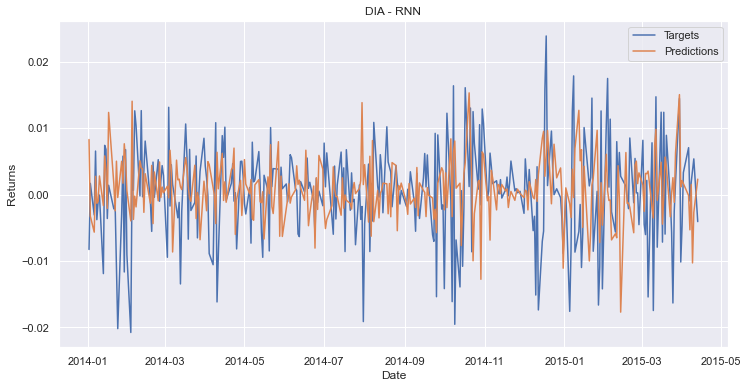




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020697 / Val Loss : 0.013874
[00:37] Epoch 100/200 - Train Loss : 0.013788 / Val Loss : 0.007073
[01:16] Epoch 200/200 - Train Loss : 0.013757 / Val Loss : 0.007218
Train MAE : 0.0866 | Train MAPE  : 0.1666 | Train RMSE : 0.1172 | Train Theil-U 0.1006
Valid MAE : 0.0702 | Valid MAPE  : 0.1168 | Valid RMSE : 0.0850 | Valid Theil-U 0.0735
Normalized Test MAE : 0.006792 | Test MAPE  : 15331.898933 | Test RMSE : 0.008287 | Test Theil-U 0.724052
Test MAE : 0.006792 | Test MAPE  : 297275368225336.250000 | Test RMSE : 0.008287 | Test Theil-U 0.724052


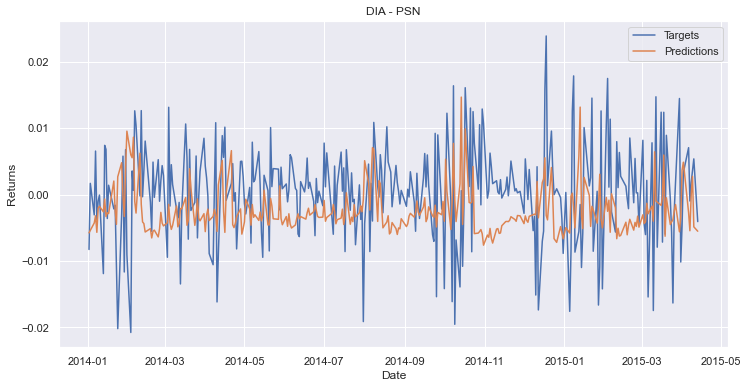




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.034164 / Val Loss : 1.003844
[00:39] Epoch 100/500 - Train Loss : 0.934973 / Val Loss : 0.972907
[01:18] Epoch 200/500 - Train Loss : 0.796258 / Val Loss : 1.048495
[01:57] Epoch 300/500 - Train Loss : 0.753054 / Val Loss : 1.109740
[02:36] Epoch 400/500 - Train Loss : 0.733377 / Val Loss : 1.134167
[03:15] Epoch 500/500 - Train Loss : 0.721183 / Val Loss : 1.144826
Train MAE : 0.6576 | Train MAPE  : 3.6425 | Train RMSE : 0.8312 | Train Theil-U 0.5402
Valid MAE : 0.8018 | Valid MAPE  : 4.8156 | Valid RMSE : 1.0700 | Valid Theil-U 0.6984
Normalized Test MAE : 0.007368 | Test MAPE  : 7.210790 | Test RMSE : 0.009821 | Test Theil-U 0.715097
Test MAE : 0.007434 | Tes

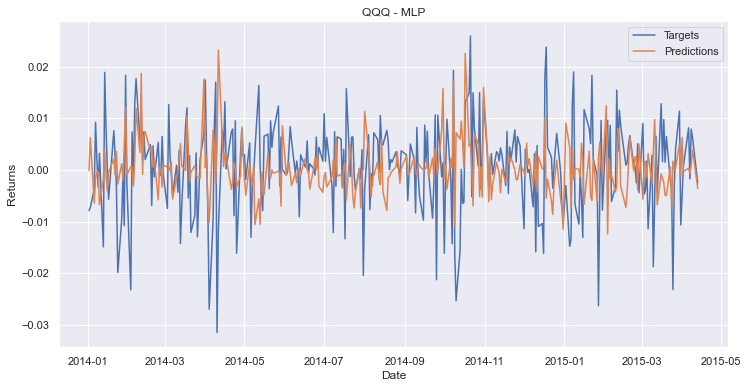




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.023271 / Val Loss : 1.002601
[00:56] Epoch 100/500 - Train Loss : 0.713641 / Val Loss : 1.180708
[01:53] Epoch 200/500 - Train Loss : 0.655493 / Val Loss : 1.334213
[02:58] Epoch 300/500 - Train Loss : 0.631747 / Val Loss : 1.438535
[03:48] Epoch 400/500 - Train Loss : 0.590146 / Val Loss : 1.529771
[04:36] Epoch 500/500 - Train Loss : 0.580180 / Val Loss : 1.541051
Train MAE : 0.5857 | Train MAPE  : 3.0399 | Train RMSE : 0.7464 | Train Theil-U 0.4445
Valid MAE : 0.9477 | Valid MAPE  : 5.4322 | Valid RMSE : 1.2414 | Valid Theil-U 0.6951
Normalized Test MAE : 0.008207 | Test MAPE  : 6.066698 | Test RMSE : 0.010579 | Test Theil-U 0.725547
Test MAE : 0.008304 | Test MAPE  : 251.817842 | Test RMSE : 0.010610 | Test Theil-U

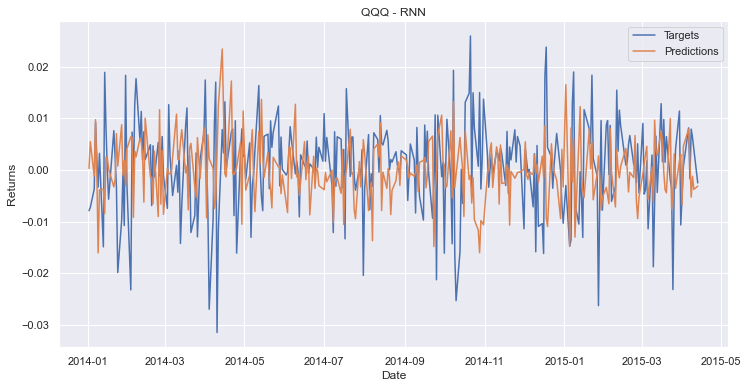




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011346
[00:35] Epoch 100/200 - Train Loss : 0.014369 / Val Loss : 0.005901
[01:07] Epoch 200/200 - Train Loss : 0.014058 / Val Loss : 0.006171
Train MAE : 0.0888 | Train MAPE  : 0.1709 | Train RMSE : 0.1169 | Train Theil-U 0.1023
Valid MAE : 0.0622 | Valid MAPE  : 0.1080 | Valid RMSE : 0.0786 | Valid Theil-U 0.0693
Normalized Test MAE : 0.007470 | Test MAPE  : 4226.043684 | Test RMSE : 0.009285 | Test Theil-U 0.758173
Test MAE : 0.007470 | Test MAPE  : 189770806245170.625000 | Test RMSE : 0.009285 | Test Theil-U 0.758173


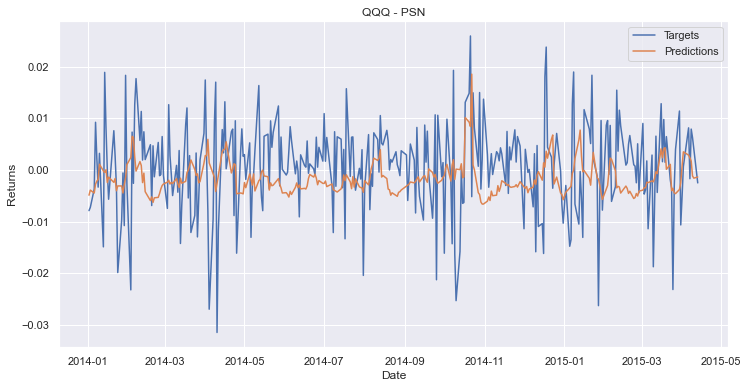

In [4]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']: 
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
            validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
            testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

        else:
            max_ = traindf.Return.max()
            min_ = traindf.Return.min()
            
            traindf = (traindf - min_) / (max_ - min_)
            validdf = (validdf - min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)
            
            
        model = NN.Model(NNtype)
        epochs = 200
#         epochs = 200 if NNtype == "PSN" else 500 # change to 300 to avoid overfitting
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    epochs,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        
        if NNtype == "PSN":
            model.evaluate(testloader, min_=min_, max_=max_)
            preds = model.predict(testloader, min_=min_, max_=max_)
            labels = testdf["Target"]*(max_ - min_) + min_
        else :
            model.evaluate(testloader, sigma=testsigma, mu=testmu)
            preds = model.predict(testloader, sigma=testsigma, mu=testmu)
            labels = np.array(testdf["Target"].tolist())
        
        testRMSE = np.sqrt(mean_squared_error(labels, preds))
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = 100 * mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        
        sns.set()
        fig, ax = plt.subplots(figsize = (12,6))
        sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

#         x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
#         ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [5]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [43]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.005390 | Test MAPE  : 1.079670 | Test RMSE : 0.007245 | Test Theil-U 0.926919


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined